Let us show that velocity estimation based on slam-seq data gives more consistent and clean results. 
Note that this is irrespective of the velocity tools you will use. Original scSLAM-seq authors show that velocyto gives better results when using slam-seq data. Here I am using the same result with the recently improved scvelo package. Please come back to see the result with dynamo! 

In [1]:
import pandas as pd 
import numpy as np 

import scanpy as sc
import scvelo as scv

# data from Hendriks et al. 2018 

Let us first run velocity estimation based on splicing data

use wget to download the raw_data_loom_combined file and then load the loom data 

wget https://www.dropbox.com/s/a9ozcynpxudqdis/raw_data_loom_combined.loom?dl=1

here I just use data I have in my local directory

In [36]:
adata_MCMV = sc.read_loom('/home/xqiu/proj/dynamo/notebook_data/raw_data_loom_combined.loom')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [37]:
# add a treatment label to the adata_MCMV object
import re
batch = list()

for cell in adata_MCMV.obs.index.values:
    regex = re.compile('3LF70')
    result = regex.search(cell)
    if result is not None:
        label = 'mock'
    else:
        label = 'mcmv'
    batch.append(label)

# add it to the adata_MCMV object
adata_MCMV.obs['virus'] = np.array(batch)

In [38]:
adata_MCMV

AnnData object with n_obs × n_vars = 1146 × 56007 
    obs: 'drug'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 39522 genes that are detected in less than 15 counts (spliced).
Filtered out 5172 genes that are detected in less than 10 counts (unspliced).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00.92) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on distances
    finished (0:00:00.05) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00.02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00.36) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


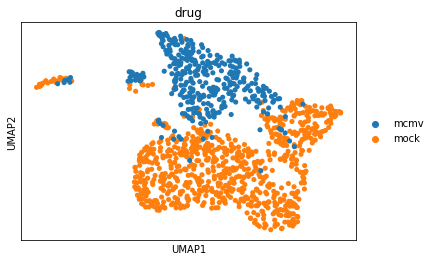

In [29]:
scv.pp.filter_and_normalize(adata_MCMV, min_counts=15, min_counts_u=10, n_top_genes=500) # n_top_genes can be tuned 
scv.pp.moments(adata_MCMV, n_pcs = 10, n_neighbors = 15, mode = 'distances') # 
scv.tl.velocity(adata_MCMV)
scv.tl.velocity_graph(adata_MCMV)

scv.tl.umap(adata_MCMV)
sc.pl.umap(adata_MCMV, color=['virus'])

computing velocity graph
    finished (0:00:00.34) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00.22) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 432x288 with 0 Axes>

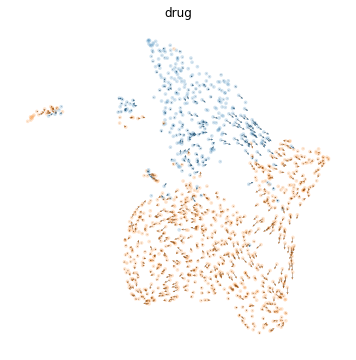

<Figure size 432x288 with 0 Axes>

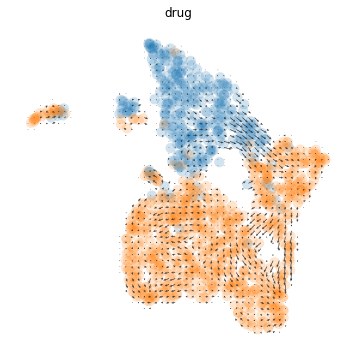

In [30]:
# scv.tl.umap(adata_slamseq)
scv.tl.velocity_graph(adata_MCMV)
scv.pl.velocity_embedding(adata_MCMV, color=['virus'], basis='umap', figsize=[6, 6])

scv.pl.velocity_embedding_grid(adata_MCMV, color=['virus'], basis='umap', figsize=[6, 6])


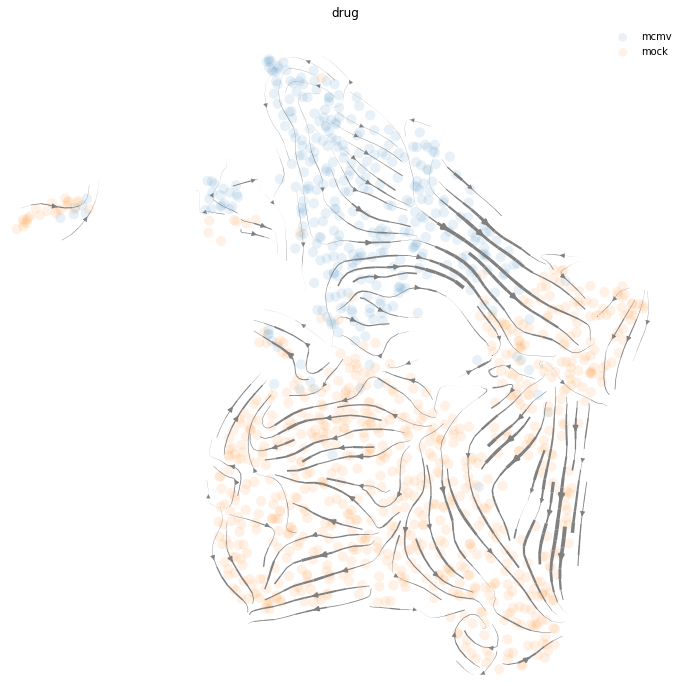

In [32]:
adata_MCMV_res = scv.pl.velocity_embedding_stream(adata_MCMV, color=['virus'], basis='umap', legend_loc=None, figsize=[12, 12], show=False, linewidth=2)
# intron_mcmv.figure.savefig('/home/xqiu/proj/dynamo/figures/intron_mcmv.svg') # save the figure 

The above velocity estimation results are kind messy. Next, let us try velocity estimation based on scSLAM-seq data. 

Note that we use total RNA (labelled new RNA + unlabeled old RNA) as **spliced** while the new RNA as **unspliced**

In [39]:
tot_RNA = pd.read_csv('https://www.dropbox.com/s/skgesrran9d48oy/emat_tot.txt?dl=1', index_col=0, delimiter='\s')
new_RNA = pd.read_csv('https://www.dropbox.com/s/kz0xj8hw4tbab9r/smat_new.txt?dl=1', index_col=0, delimiter='\s')

from anndata import AnnData
adata_sc_slamseq_MCMV = AnnData(tot_RNA.values.T,
    layers=dict(
        unspliced=new_RNA.values.T,
        spliced = tot_RNA.values.T)) 
adata_sc_slamseq_MCMV

# again, let annotate cells by virus infection
batch = list()

for cell in tot_RNA.columns.values:
    regex = re.compile('mock')
    result = regex.search(cell)
    if result is not None:
        label = 'mock'
    else:
        label = 'mcmv'
    batch.append(label)
    
# add it to the vlm object
adata_sc_slamseq_MCMV.obs['virus'] = np.array(batch)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [40]:
scv.pp.filter_and_normalize(adata_sc_slamseq_MCMV, min_counts=1, min_counts_u=1, n_top_genes=583)
scv.pp.moments(adata_sc_slamseq_MCMV, n_pcs = 10, n_neighbors = 15, mode = 'distances') # 
scv.tl.velocity(adata_sc_slamseq_MCMV)
scv.tl.velocity_graph(adata_sc_slamseq_MCMV)

Filtered out 19 genes that are detected in less than 1 counts (unspliced).
Skip filtering by dispersion since number of variables are less than `n_top_genes`
Logarithmized X.
computing neighbors
    finished (0:00:00.11) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on distances
    finished (0:00:00.01) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00.00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00.03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00.03) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


<Figure size 432x288 with 0 Axes>

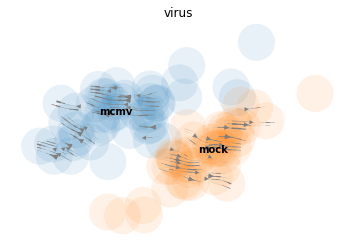

In [41]:
scv.pl.velocity_embedding_stream(adata_sc_slamseq_MCMV, color = ['virus'])


computing velocity embedding
    finished (0:00:00.04) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 432x288 with 0 Axes>

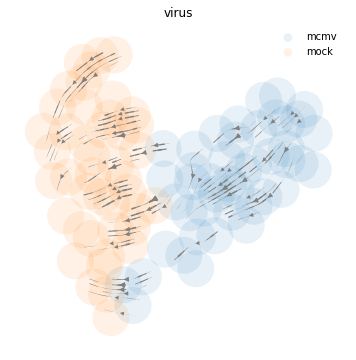

In [42]:
scv.tl.umap(adata_sc_slamseq_MCMV)

scv.pl.velocity_embedding_stream(adata_sc_slamseq_MCMV, basis='umap', color=['virus'], figsize=[6, 6], legend_loc=None)


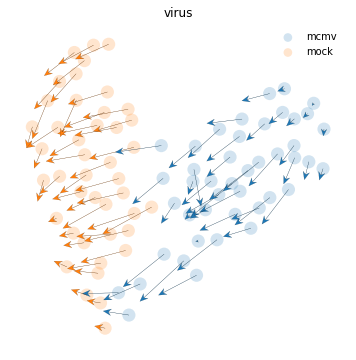

In [43]:
scv.pl.velocity_embedding(adata_sc_slamseq_MCMV, basis='umap', color=['virus'], figsize=[6, 6], arrow_size=4, arrow_length=5, legend_loc=None)


the velocity estimation here is much more apparent and consistent. let us save the result 

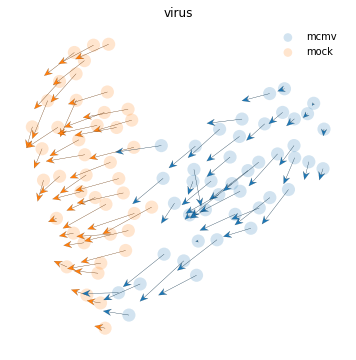

In [44]:
slamseq_mcmv = scv.pl.velocity_embedding(adata_sc_slamseq_MCMV, basis='umap', color=['virus'], figsize=[6, 6], arrow_size=4, arrow_length=5, legend_loc=None)

# slamseq_mcmv.figure.savefig('/home/xqiu/proj/dynamo/figures/slamseq_mcmv.svg')


# HL60 scSLAM-seq data by us 

In [46]:
expr_cnt = pd.read_csv('https://www.dropbox.com/s/5u6f48rohhfxt7a/190610_scslam.csv?dl=1', index_col=0)
sample_sheet = pd.read_csv('https://www.dropbox.com/s/cc93r5shm5ne873/2019-06-06_sample_sheet.csv?dl=1')
platemap_scSLAM = pd.read_csv('https://www.dropbox.com/s/qooq3hnigxsx9q2/384platemap_scSLAM.csv?dl=1', index_col=0)

In [47]:
expr_cnt.columns = expr_cnt.columns.str.split('_').str[0]

In [48]:
sample_sheet = sample_sheet.set_index(sample_sheet.Sample_ID.str.split('_').str[0])


In [49]:
print(expr_cnt.shape, sample_sheet.shape)

(26582, 351) (384, 16)


In [50]:
expr_cnt = expr_cnt.drop(['Undetermined'], axis=1)
expr_cnt = expr_cnt.drop(['__no_feature', '__ambiguous', '__too_low_aQual', 
                          '__not_aligned', '__alignment_not_unique'], axis=0)
expr_cnt.shape

(26577, 350)

In [51]:
sample_sheet = sample_sheet.loc[expr_cnt.columns, :]
sample_sheet['drug'] = sample_sheet.Sample_Name.str.split('_').str[0]
sample_sheet['cell_type'] = sample_sheet.Sample_Name.str.split('_').str[1]
sample_sheet['s4U'] = sample_sheet.Sample_Name.str.split('_').str[2]

sample_sheet.shape

(350, 19)

In [52]:
import anndata 
import scipy

In [53]:
print(expr_cnt.shape, sample_sheet.shape)
adata = anndata.AnnData(X=expr_cnt.T,obs = sample_sheet)

(26577, 350) (350, 19)


In [54]:
adata.obs = sample_sheet

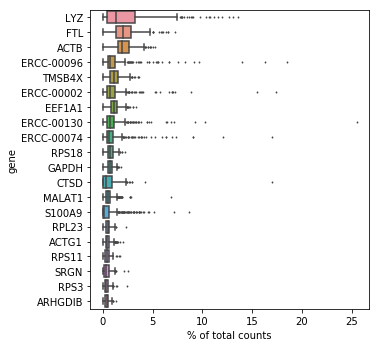

In [55]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [56]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=1)

In [57]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)


... storing 'Study_Description' as categorical
... storing 'BioSample_Description' as categorical
... storing 'Sample_Name' as categorical
... storing 'Sample_Owner' as categorical
... storing 'Organism' as categorical
... storing 'Tissue_Source' as categorical
... storing 'drug' as categorical
... storing 'cell_type' as categorical
... storing 's4U' as categorical


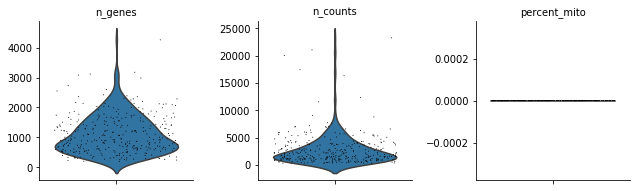

In [58]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

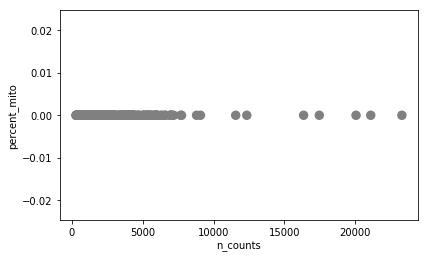

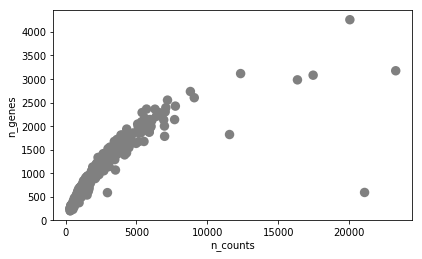

In [59]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [61]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)


In [62]:
sc.pp.log1p(adata)


In [63]:
adata.var['is_ERCC'] = adata.var.index.str.match('ERCC-')
adata = adata[:, ~ adata.var['is_ERCC']]
# ERCC_genes = adata.var_names.str.startswith('ERCC-')

# adata = adata[:, ~ERCC_genes]
# adata

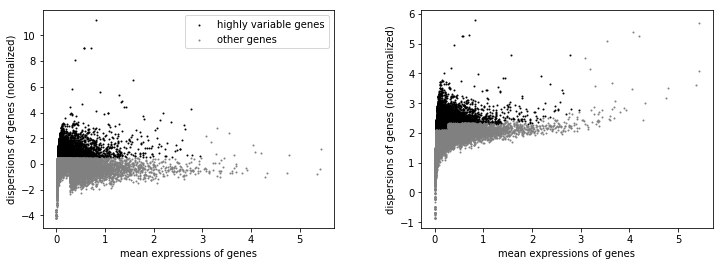

In [64]:

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


In [65]:
adata = adata[:, adata.var['highly_variable']]


In [66]:
sc.pp.regress_out(adata, ['n_counts'])


In [67]:
sc.pp.scale(adata, max_value=10)


In [68]:
sc.tl.pca(adata, svd_solver='arpack')


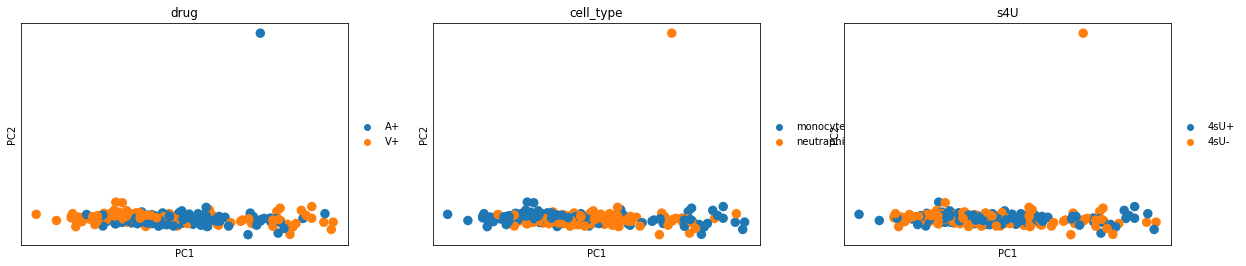

In [69]:
sc.pl.pca(adata, color=['drug', 'cell_type', 's4U'])


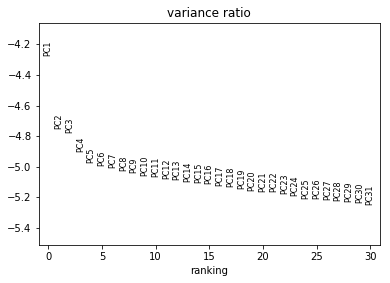

In [70]:
sc.pl.pca_variance_ratio(adata, log=True)


In [71]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)


In [72]:
sc.tl.umap(adata)

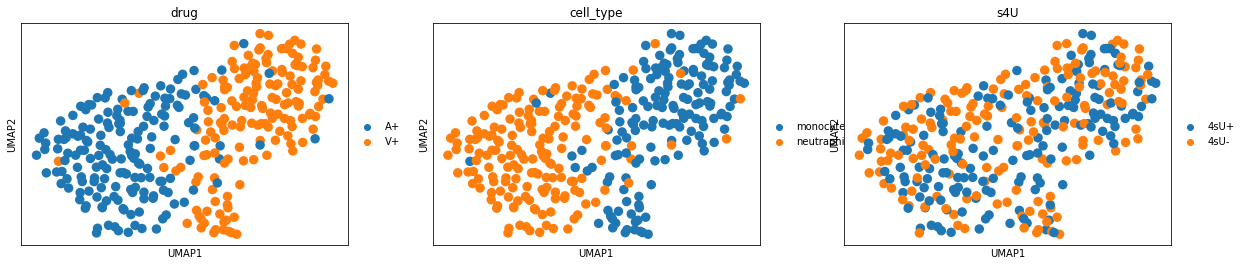

In [73]:
sc.pl.umap(adata, color = ['drug', 'cell_type', 's4U'])

So the above results show that even with very shollow sequencing (only 10 k reads / cell), we can distinguish cells treated with ATRA or VD3 well. 

we can calculate the absolute transcript counts with the linear regression model we discussed previously (Xiaojie Qiu, et. al, 2017). I am leaving it for now

```concentration = pd.read_table('ERCC_Controls_Analysis.txt', index_col=1)['concentration in Mix 1 (attomoles/ul)']```

```ercc_molecules = concentration * (9 * 1e-3 * 1./40000 * 1e-18 * 6.02214129 * 1e23)```

We will again first run velocity estimation with splicing-only data. 

use wget to download the raw_data_loom_combined file and then load the loom data 

wget https://www.dropbox.com/s/ng64dagia2p2bfy/onefilepercell_A10_scSLAM_S10_and_others_RSP38.loom?dl=1

here I just use data I have in my local directory

In [74]:
adata_loom = sc.read_loom('/home/xqiu/proj/dynamo/notebook_data/onefilepercell_A10_scSLAM_S10_and_others_RSP38.loom')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [75]:
well_id = adata_loom.obs.index.str.split(':').str[1].str.split('_').str[0]
adata_loom.obs = adata_loom.obs.set_index(well_id)

In [76]:
scv.pp.filter_and_normalize(adata_loom, min_counts=2, min_counts_u=1, n_top_genes=1500)
scv.pp.moments(adata_loom, n_pcs = 10, n_neighbors = 15, mode = 'distances') # 
scv.tl.velocity(adata_loom)
scv.tl.velocity_graph(adata_loom)


Filtered out 22623 genes that are detected in less than 2 counts (spliced).
Filtered out 3034 genes that are detected in less than 1 counts (unspliced).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00.32) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on distances
    finished (0:00:00.02) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00.02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00.07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [77]:
adata_loom.obs = pd.concat([adata_loom.obs, sample_sheet.loc[well_id, :]], axis=1)

computing velocity embedding
    finished (0:00:00.04) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


<Figure size 432x288 with 0 Axes>

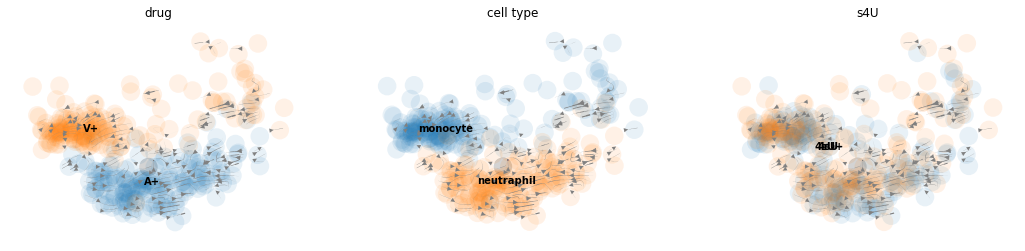

In [78]:
scv.pl.velocity_embedding_stream(adata_loom, color=['drug', 'cell_type', 's4U'])

We sequenced  172 4sU labelled cells

In [79]:
sum(adata_loom.obs['s4U'] == '4sU+')

172

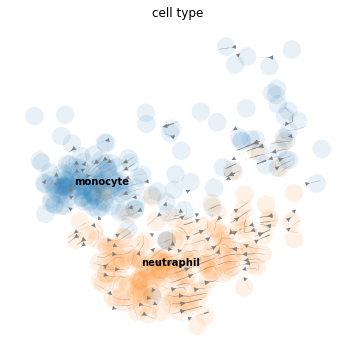

In [80]:
scv.pl.velocity_embedding_stream(adata_loom, color=['cell_type'], figsize=[6, 6])

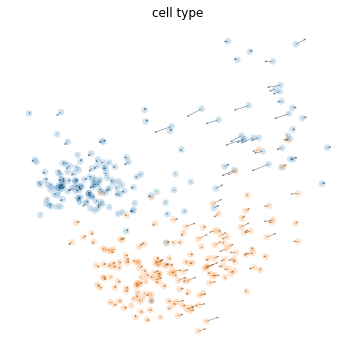

In [81]:
scv.pl.velocity_embedding(adata_loom, color=['cell_type'], figsize=[6, 6])

In [82]:
scv.pp.filter_genes(adata_loom, min_shared_counts=3)
scv.pp.normalize_per_cell(adata_loom)
scv.pp.filter_genes_dispersion(adata_loom, n_top_genes=3000)
scv.pp.log1p(adata_loom)

Filtered out 993 genes that are detected in less than 3 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`


In [83]:
scv.pp.filter_and_normalize(adata_loom, min_shared_counts=3, n_top_genes=3000)
scv.pp.moments(adata_loom, n_pcs=15, n_neighbors=15)

Skip filtering by dispersion since number of variables are less than `n_top_genes`
Did not modify X as it looks preprocessed already.
computing moments based on connectivities
    finished (0:00:00.01) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


In [84]:
scv.tl.velocity(adata_loom)


computing velocities
    finished (0:00:00.01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [85]:
scv.tl.velocity_graph(adata_loom)


computing velocity graph
    finished (0:00:00.08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [86]:
scv.tl.umap(adata_loom)

computing velocity embedding
    finished (0:00:00.11) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 432x288 with 0 Axes>

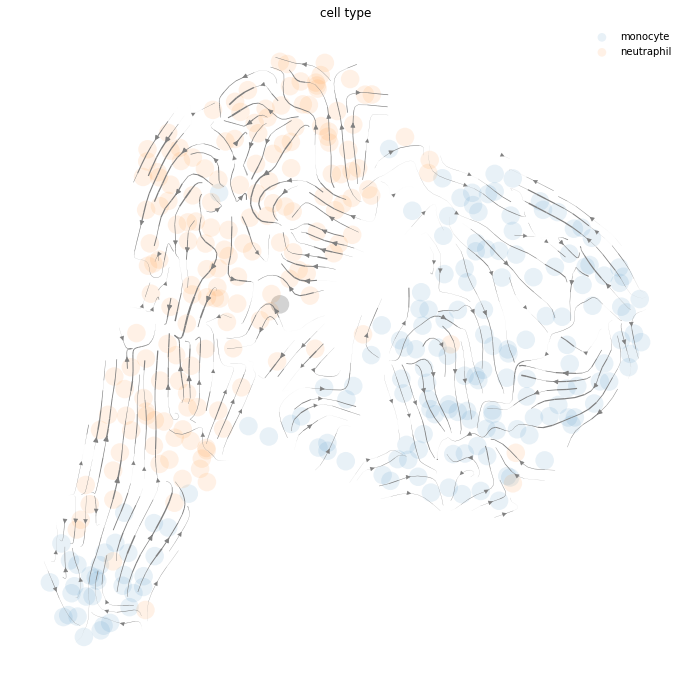

In [87]:
p1 = scv.pl.velocity_embedding_stream(adata_loom, basis='umap', color=['cell_type'], figsize=[12, 12], legend_loc = None, show = False)
# p1.figure.savefig('/home/xqiu/proj/dynamo/figures/HL60_splicing_data.svg')

<Figure size 432x288 with 0 Axes>

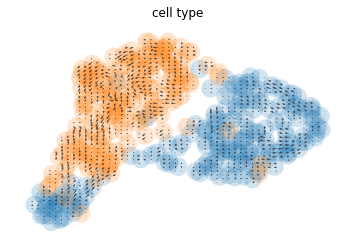

In [88]:
scv.pl.velocity_embedding_grid(adata_loom, basis='umap', color=['cell_type'])


# HL60 scSLAM-seq data

In [90]:
new_RNA = pd.read_csv('https://www.dropbox.com/s/kxej0h2p69ajf7l/slam_seq_newTable.csv?dl=1', index_col=0)
old_RNA = pd.read_csv('https://www.dropbox.com/s/3df72kg7drnid8t/slam_seq_oldTable.csv?dl=1', index_col=0)


In [91]:
# our sequencing is very shallow so a lot cells didn't pass filter to quantify mutation reads 
cellFilter = pd.read_csv('https://www.dropbox.com/s/w3p641o4afmc0k5/cellFilter.txt?dl=1', header=None)

In [92]:
filtered_cellName = cellFilter[0].str.split('_').str[1]

In [93]:
new_RNA.fillna(0, inplace=True)
old_RNA.fillna(0, inplace=True)
old_RNA.shape

(176, 58768)

In [94]:
from anndata import AnnData
adata_slamseq = AnnData(new_RNA.values + old_RNA.values,
    layers=dict(
        unspliced=new_RNA.values,
        spliced = old_RNA.values + new_RNA.values))
adata_slamseq

AnnData object with n_obs × n_vars = 176 × 58768 
    layers: 'unspliced', 'spliced'

In [95]:
adata_slamseq.obs = adata_slamseq.obs.set_index(new_RNA.index.str.split('_').str[1])
tmp = adata_loom.obs.loc[adata_slamseq.obs.index.values, :]

adata_slamseq.obs = pd.concat([adata_slamseq.obs, tmp.iloc[:, 4:]], axis=1)

In [96]:
adata_slamseq = adata_slamseq[filtered_cellName.values]

In [97]:
scv.utils.show_proportions(adata_slamseq)


Abundance of ['spliced', 'unspliced']: [0.86 0.14]


In [98]:
scv.utils.show_proportions(adata_loom)


Abundance of ['spliced', 'unspliced', 'ambiguous']: [0.93 0.04 0.03]


In [99]:
adata_slamseq = adata_slamseq[np.where([i is not np.nan for i in adata_slamseq.obs.Index.values])]

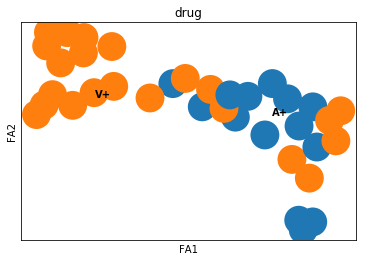

In [100]:
# sc.pp.recipe_zheng17(adata_slamseq) 
sc.tl.pca(adata_slamseq, svd_solver='arpack', n_comps=30)
sc.pp.neighbors(adata_slamseq, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata_slamseq)
sc.pl.draw_graph(adata_slamseq, color='drug', legend_loc='on data')


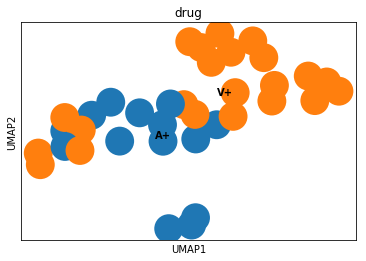

In [101]:
sc.tl.umap(adata_slamseq)
sc.pl.umap(adata_slamseq, color='drug', legend_loc='on data')


In [102]:
scv.tl.velocity(adata_slamseq)
scv.tl.velocity_graph(adata_slamseq)

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00.04) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00.21) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00.00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [695]:
pos = [list(adata_loom.obs.Index.values).index(i) for i in adata_slamseq.obs.Index.values]
# adata_slamseq.obsm['X_umap'] = adata_loom.obsm['X_umap'][pos]

In [103]:
scv.pp.filter_and_normalize(adata_slamseq, min_counts=10, min_counts_u=1, n_top_genes=1000)
scv.pp.moments(adata_slamseq, n_pcs = 10, n_neighbors = 5, mode = 'connectivities') # 

scv.tl.velocity(adata_slamseq)
scv.tl.velocity_graph(adata_slamseq)

Filtered out 58617 genes that are detected in less than 10 counts (spliced).
Filtered out 42 genes that are detected in less than 1 counts (unspliced).
Skip filtering by dispersion since number of variables are less than `n_top_genes`
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00.00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00.00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00.01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


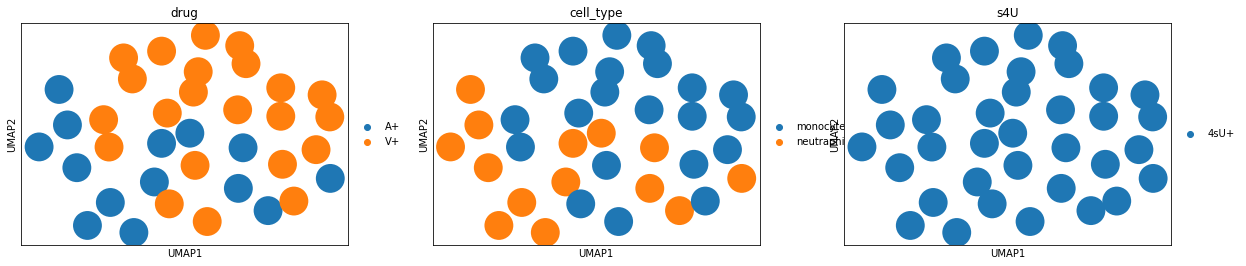

In [104]:
scv.tl.umap(adata_slamseq)
sc.pl.umap(adata_slamseq, color=['drug', 'cell_type', 's4U'])

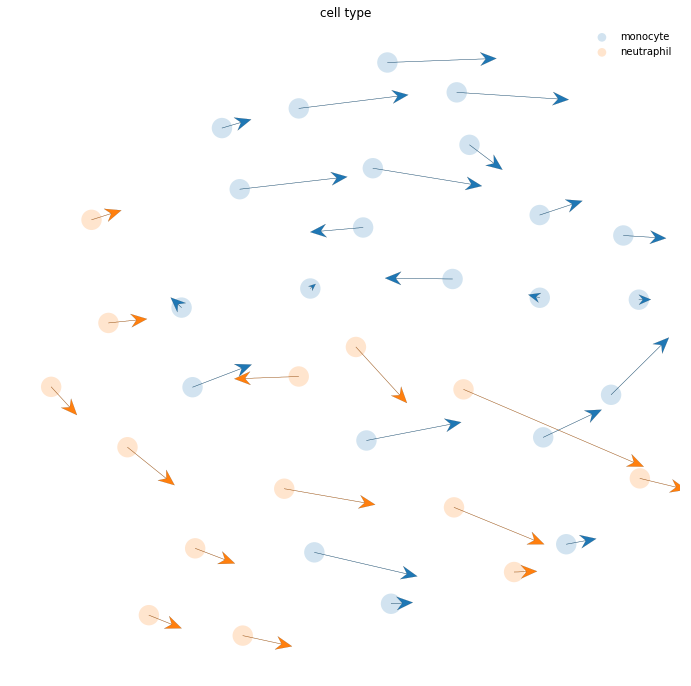

In [106]:
p2 = scv.pl.velocity_embedding(adata_slamseq, basis='umap', color=['cell_type'], figsize=[12, 12], 
                          arrow_size=4, arrow_length=5, legend_loc=None, show = False)
# p2.figure.savefig('/home/xqiu/proj/dynamo/figures/HL60_slam_seq.svg')

In [ ]:
readCounts = pd.read_csv('/home/xqiu/proj/slam_seq/Experimentdir/outfiles/readCounts.csv', index_col=0)
max(readCounts.sum(axis=1))

In [ ]:
readCounts.shape

In [ ]:
adata_slamseq.shape

In [388]:
adata_readCounts = anndata.AnnData(X=readCounts,obs = sample_sheet)

In [389]:
adata_readCounts

AnnData object with n_obs × n_vars = 176 × 58768 

In [237]:
adata_loom.obs.index

Index(['A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19',
       ...
       'P21', 'P22', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P9', 'Undetermined'],
      dtype='object', length=349)

In [239]:
adata_readCounts.obs = adata_readCounts.obs.set_index(readCounts.index.str.split('_').str[1])


In [243]:
tmp = adata_slamseq.obs.loc[adata_readCounts.obs.index.values, :]

# tmp

In [244]:
adata_readCounts.obs = pd.concat([adata_readCounts.obs, tmp.iloc[:, 4:]], axis=1)

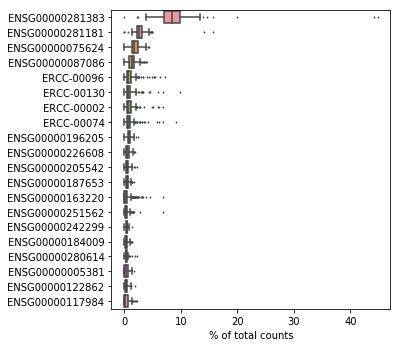

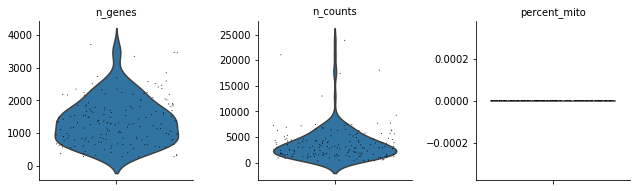

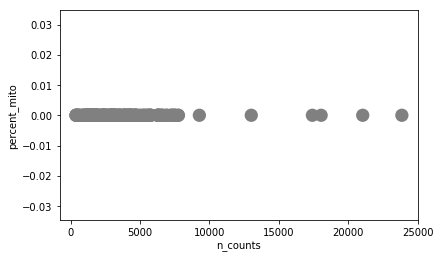

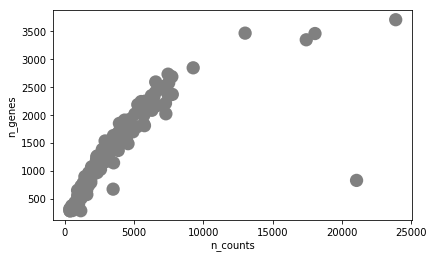

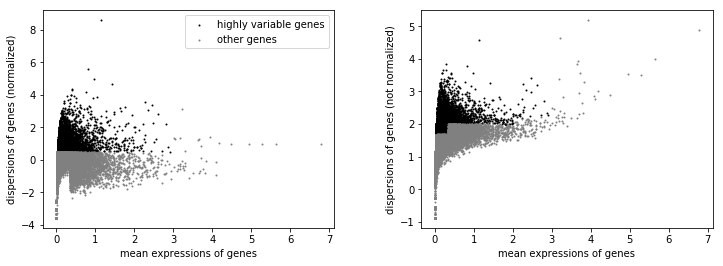

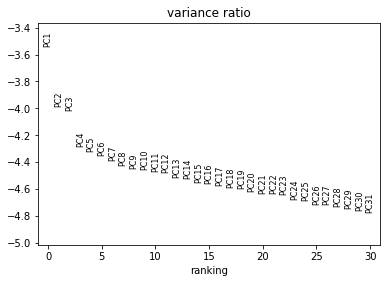

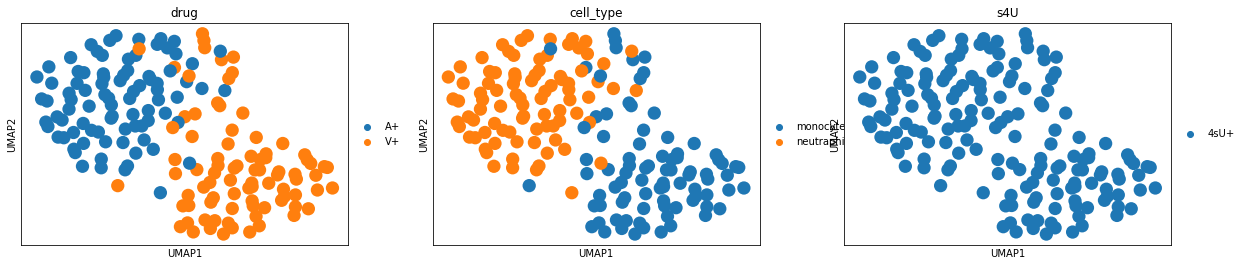

In [247]:
sc.pl.highest_expr_genes(adata_readCounts, n_top=20)
sc.pp.filter_cells(adata_readCounts, min_genes=200)
sc.pp.filter_genes(adata_readCounts, min_cells=1)
mito_genes = adata_readCounts.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata_readCounts.obs['percent_mito'] = np.sum(
    adata_readCounts[:, mito_genes].X, axis=1) / np.sum(adata_readCounts.X, axis=1)
# add the total counts per cell as observations-annotation to adata_readCounts
adata_readCounts.obs['n_counts'] = adata_readCounts.X.sum(axis=1)
sc.pl.violin(adata_readCounts, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_readCounts, x='n_counts', y='percent_mito')
sc.pl.scatter(adata_readCounts, x='n_counts', y='n_genes')
sc.pp.normalize_per_cell(adata_readCounts, counts_per_cell_after=1e4)
sc.pp.log1p(adata_readCounts)
adata_readCounts.var['is_ERCC'] = adata_readCounts.var.index.str.match('ERCC-')
adata_readCounts = adata_readCounts[:, ~ adata_readCounts.var['is_ERCC']]
sc.pp.highly_variable_genes(adata_readCounts, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata_readCounts)
adata_readCounts = adata_readCounts[:, adata_readCounts.var['highly_variable']]
sc.pp.regress_out(adata_readCounts, ['n_counts'])
sc.pp.scale(adata_readCounts, max_value=10)
sc.tl.pca(adata_readCounts, svd_solver='arpack')
sc.tl.pca(adata_readCounts, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_readCounts, log=True)
sc.pp.neighbors(adata_readCounts, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata_readCounts)
sc.pl.umap(adata_readCounts, color = ['drug', 'cell_type', 's4U'])


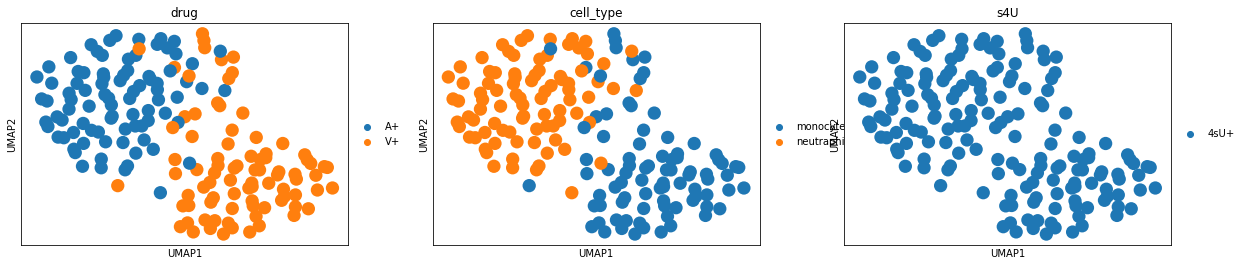

In [258]:
adata_slamseq2 = adata_slamseq[adata_readCounts.obs.index]
pos = [list(adata_readCounts.obs.index.values).index(i) for i in adata_slamseq2.obs.index.values]
adata_slamseq2.obsm['X_umap'] = adata_readCounts.obsm['X_umap'][pos]
sc.pl.umap(adata_slamseq2, color=['drug', 'cell_type', 's4U'])



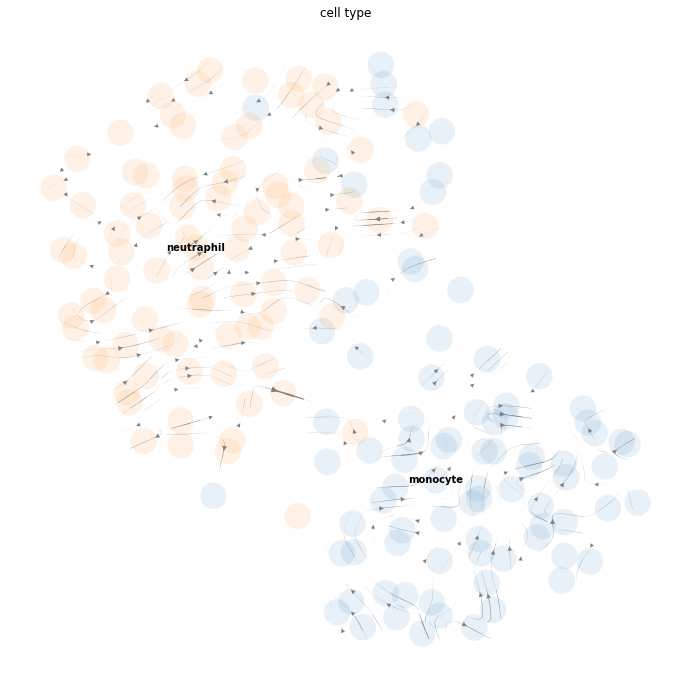

In [259]:
scv.pl.velocity_embedding_stream(adata_slamseq2, basis = 'umap', color=['cell_type'], figsize=[12, 12])

In [ ]:
# rerun the NASC-seq pipeline 
# reproduce the scSLAM-seq vector field plot 

In [ ]:
# check whether this count matches up with Shayan's output 


In [234]:
slam_seq_mode = pd.read_csv('/home/xqiu/proj/slam_seq/Experimentdir/outfiles/slam_seq_mode.csv', index_col=0)
len(slam_seq_mode)

0

In [ ]:
# 1. remove cells that are not labelled and redo the NASC-seq again? 


In [ ]:
# import yt
# ds = yt.load("/home/xqiu/share/LIC/WDMerger_hdf5_chk_1000/WDMerger_hdf5_chk_1000.hdf5")
# s = yt.SlicePlot(ds, 'z', 'density', center='c', width=(20, 'kpc'))
# s.annotate_line_integral_convolution('velocity_x', 'velocity_y', lim=(0.5,0.65))
# s.save()

yt : [INFO     ] 2019-06-26 11:04:44,266 Particle file found: WDMerger_hdf5_chk_1000.hdf5
yt : [WARNING  ] 2019-06-26 11:04:44,280 Extending theta dimension to 2PI + left edge.
yt : [INFO     ] 2019-06-26 11:04:44,301 Parameters: current_time              = 10000.005277417175
yt : [INFO     ] 2019-06-26 11:04:44,302 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2019-06-26 11:04:44,303 Parameters: domain_left_edge          = [ 0.0000e+00 -6.5536e+09  0.0000e+00]
yt : [INFO     ] 2019-06-26 11:04:44,304 Parameters: domain_right_edge         = [1.31072000e+10 6.55360000e+09 6.28318531e+00]
yt : [INFO     ] 2019-06-26 11:04:44,305 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-06-26 11:04:44,308 Setting origin='native' for cylindrical geometry.
yt : [INFO     ] 2019-06-26 11:04:44,779 xlim = -10.000000 10.000000
yt : [INFO     ] 2019-06-26 11:04:44,781 ylim = -10.000000 10.000000
yt : [INFO     ] 2019-06-26 11:04:44,783 xlim = -10.000000 10.00000

In [50]:
import yt
ds = yt.load("/home/xqiu/share/LIC/IsolatedGalaxy/galaxy0030/galaxy0030")
s = yt.SlicePlot(ds, 'z', 'density', center='c', width=(20, 'kpc'))
s.annotate_line_integral_convolution('velocity_x', 'velocity_y', lim=(0.5,0.65))
s.save()

yt : [INFO     ] 2019-06-26 12:53:13,114 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2019-06-26 12:53:13,114 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2019-06-26 12:53:13,115 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2019-06-26 12:53:13,116 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2019-06-26 12:53:13,117 Parameters: cosmological_simulation   = 0.0
Parsing Hierarchy : 100%|██████████| 173/173 [00:00<00:00, 9144.14it/s]
yt : [INFO     ] 2019-06-26 12:53:13,167 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2019-06-26 12:53:16,373 xlim = 0.490001 0.509999
yt : [INFO     ] 2019-06-26 12:53:16,375 ylim = 0.490001 0.509999
yt : [INFO     ] 2019-06-26 12:53:16,377 xlim = 0.490001 0.509999
yt : [INFO     ] 2019-06-26 12:53:16,378 ylim = 0.490001 0.509999
yt : [INFO     ] 2019-06-26 12:53:16,379 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt :

['galaxy0030_Slice_z_density.png']

In [54]:
ds.all_data()

YTRegion (galaxy0030): , center=[1.543e+24 1.543e+24 1.543e+24] cm, left_edge=[0. 0. 0.] cm, right_edge=[3.086e+24 3.086e+24 3.086e+24] cm


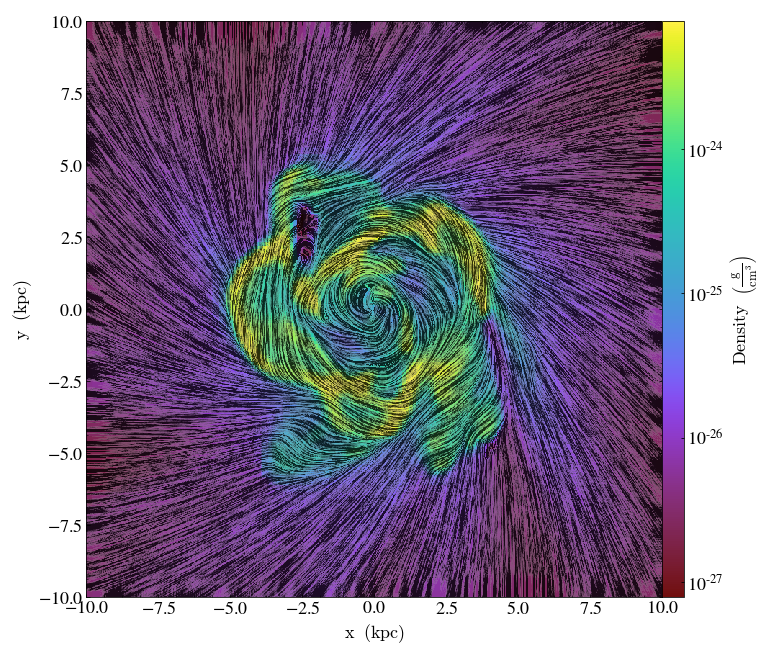

In [51]:
s.show()

In [ ]:
import astropy.io.fits as pyfits
# Or, just import pyfits if that's what you have installed

f = pyfits.open(data_dir+"/UnigridData/velocity_field_20.fits")
f.info()


# We can put it into a dictionary in the same way as before, but we slice the file handle `f` so that we don't use the `PrimaryHDU`. `hdu.name` is the field name and `hdu.data` is the actual data. Each of these velocity fields is in km/s. We can check that we got the correct fields. 

# In[ ]:


data = {}
for hdu in f:
    name = hdu.name.lower()
    data[name] = (hdu.data,"km/s")
print (data.keys())


# The velocity field names in this case are slightly different than the standard yt field names for velocity fields, so we will reassign the field names:

# In[ ]:


data["velocity_x"] = data.pop("x-velocity")
data["velocity_y"] = data.pop("y-velocity")
data["velocity_z"] = data.pop("z-velocity")


# Now we load the data into yt. Let's assume that the box size is a Mpc. Since these are velocity fields, we can overlay velocity vectors on slices, just as if we had loaded in data from a supported code. 

# In[ ]:


ds = yt.load_uniform_grid(data, data["velocity_x"][0].shape, length_unit=(1.0,"Mpc"))
slc = yt.SlicePlot(ds, "x", ["velocity_x","velocity_y","velocity_z"])
for ax in "xyz":
    slc.set_log("velocity_%s" % (ax), False)
slc.annotate_velocity()
slc.show()


In [61]:
# from licpy.lic import runlic, grey_save

# from sympy import cos, sin, pi, S
# from sympy.matrices import Matrix

# vortex_spacing = S(7) / 8
# a = Matrix([1, 0]) * vortex_spacing
# b = Matrix([cos(pi / 3), sin(pi / 3)]) * vortex_spacing


# def V(x, y):
#     σ = 1
#     vx, vy = 0, 0
#     for (n, m, s) in [
#         (0, 0, 1),
#         (1, 0, σ),
#         (0, 1, σ),
#         (-1, 0, σ),
#         (0, -1, σ),
#         (-1, 1, σ),
#         (1, -1, σ),
#     ]:
#         xv, yv = n * a + m * b
#         rr = (x - xv) ** 2 + (y - yv) ** 2
#         vx += -s * (y - yv) / rr
#         vy += +s * (x - xv) / rr

#     return vx, vy

# vx, vy = V(a, b)

# tex = runlic(vx, vy)
# grey_save(dest, tex)

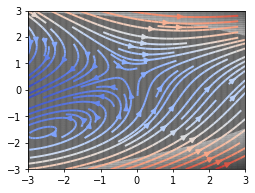

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
w = 4
h = 3
d = 70
plt.figure(figsize=(w, h), dpi=d)
Y, X = np.mgrid[-3:3:400j, -3:3:400j]
U = X + Y**2
V = 1 + X - Y

plt.quiver(X, Y, U, V)

plt.streamplot(
    X, Y, U, V, color=U, linewidth=2,
    cmap=plt.cm.coolwarm)

import matplotlib.pyplot as plt
import numpy as np


In [59]:
Y[:5, :5]

array([[-3.   , -3.   , -3.   , -3.   , -3.   ],
       [-2.985, -2.985, -2.985, -2.985, -2.985],
       [-2.97 , -2.97 , -2.97 , -2.97 , -2.97 ],
       [-2.955, -2.955, -2.955, -2.955, -2.955],
       [-2.94 , -2.94 , -2.94 , -2.94 , -2.94 ]])

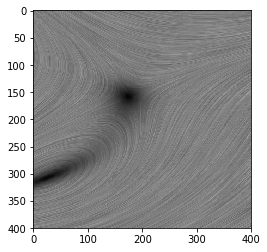

In [60]:
tex = runlic(U.T, V.T, 50)
from matplotlib import pyplot, image
import scipy

# img = scipy.misc.lena()
# tr = scipy.ndimage.rotate(texture,45)
# imshow(tr)

def grey_save(name, tex):
    tex = tex[:, ::-1]
    tex = tex.T

    M, N = tex.shape
    texture = np.empty((M, N, 4), np.float32)
    texture[:, :, 0] = tex
    texture[:, :, 1] = tex
    texture[:, :, 2] = tex
    texture[:, :, 3] = 1

#     texture = scipy.ndimage.rotate(texture,-90)
    plt.figure()
    plt.imshow(texture)
    plt.imsave(name, texture)

grey_save('/home/xqiu/tmp.png', tex)

In [65]:
def plot_LIC(U_grid, V_grid, method = 'yt'):
    '''Visualize vector field with line integral convolution (LIC), using velocity estimates on a grid from the associated data.
    A white noise background will be used for texture as default. Adjust the bounds of lim in the range of [0, 1] which applies
    upper and lower bounds to the values of line integral convolution and enhance the visibility of plots. When const_alpha=False,
    alpha will be weighted spatially by the values of line integral convolution; otherwise a constant value of the given alpha is used.

    Arguments
    ---------
        Y: 'np.ndarray'
            Original data.
        V: 'np.ndarray'
            Original data.
        sigma2: 'float'
            sigma2 is defined as sum(sum((Y - V)**2)) / (N * D)
        gamma: 'float'
            Percentage of inliers in the samples. This is an inital value for EM iteration, and it is not important.
        a: 'float'
            Paramerter of the model of outliers. We assume the outliers obey uniform distribution, and the volume of outlier's variation space is a.

    Returns
    -------
    P: 'np.ndarray'
        Posterior probability, related to equation 27.
    E: `np.ndarray'
        Energy, related to equation 26.

    '''

    if method == 'yt':
        velocity_x_ori, velocity_y_ori, velocity_z_ori = U_grid, V_grid, np.zeros(U_grid.shape)
        velocity_x = np.repeat(velocity_x_ori[:, :, np.newaxis], V_grid.shape[1], axis=2)
        velocity_y = np.repeat(velocity_y_ori[:, :, np.newaxis], V_grid.shape[1], axis=2)
        velocity_z = np.repeat(velocity_z_ori[np.newaxis, :, :], V_grid.shape[1], axis=0)

        data = {}

        data["velocity_x"] = (velocity_x, "km/s")
        data["velocity_y"] = (velocity_y, "km/s")
        data["velocity_z"] = (velocity_z, "km/s")

        ds = yt.load_uniform_grid(data, data["velocity_x"][0].shape, length_unit=(1.0,"Mpc"))
        slc = yt.SlicePlot(ds, "z", ["velocity_x","velocity_y","velocity_z"])
        for ax in "xyz":
            slc.set_log("velocity_%s" % (ax), False)
        slc.annotate_velocity()
        slc.annotate_line_integral_convolution('velocity_x', 'velocity_y', lim=(0,1))
        slc.show()
    elif method == 'lic':
        velocyto_tex = runlic(V_grid.T, V_grid.T, 100)
        plot_LIC_gray(velocyto_tex)


yt : [INFO     ] 2019-07-01 16:14:31,742 Parameters: current_time              = 0.0
yt : [INFO     ] 2019-07-01 16:14:31,743 Parameters: domain_dimensions         = [400 400 400]
yt : [INFO     ] 2019-07-01 16:14:31,744 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2019-07-01 16:14:31,745 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2019-07-01 16:14:31,746 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-07-01 16:14:32,357 xlim = 0.000000 1.000000
yt : [INFO     ] 2019-07-01 16:14:32,358 ylim = 0.000000 1.000000
yt : [INFO     ] 2019-07-01 16:14:32,359 xlim = 0.000000 1.000000
yt : [INFO     ] 2019-07-01 16:14:32,360 ylim = 0.000000 1.000000
yt : [INFO     ] 2019-07-01 16:14:32,361 Making a fixed resolution buffer of (('gas', 'velocity_x')) 800 by 800
yt : [INFO     ] 2019-07-01 16:14:32,493 Making a fixed resolution buffer of (('gas', 'velocity_y')) 800 by 800
yt : [INFO     ] 2019-07-01 16:14:32,510 Making a fixed resolut


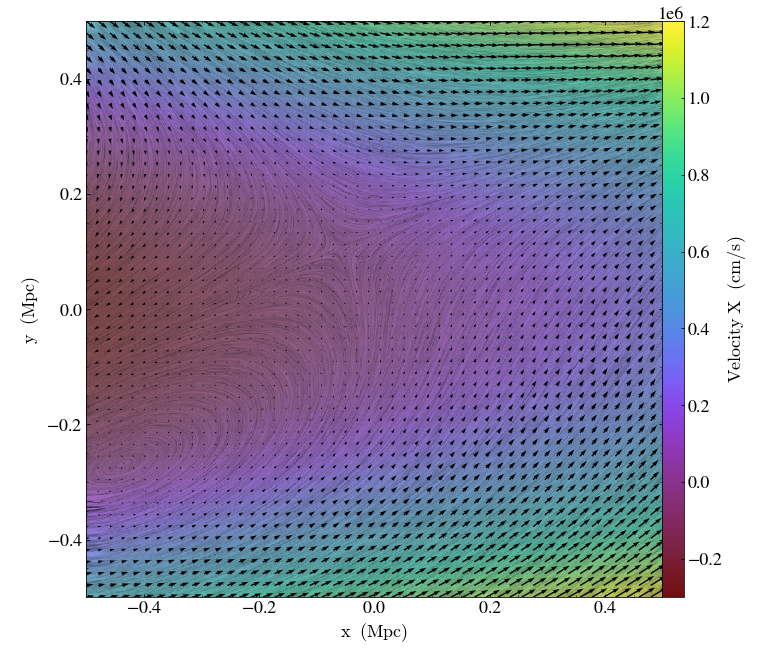
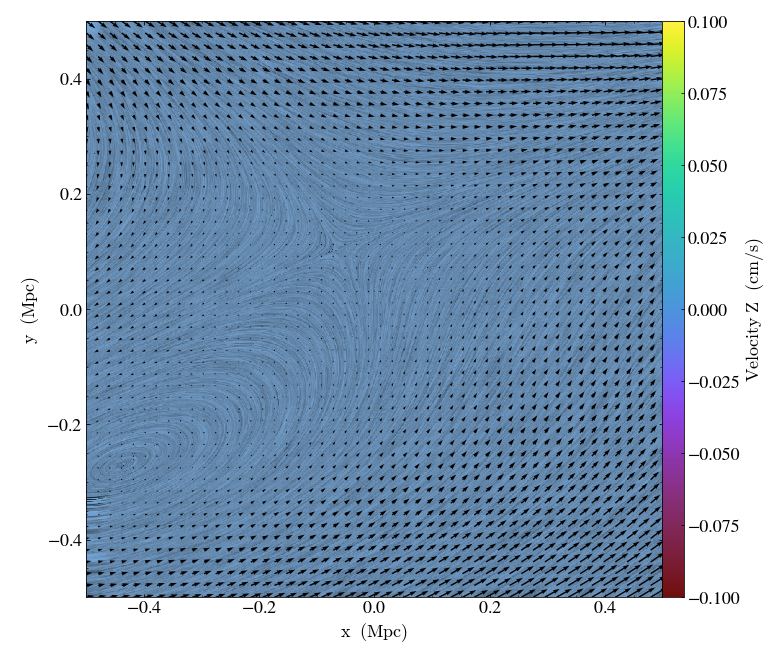
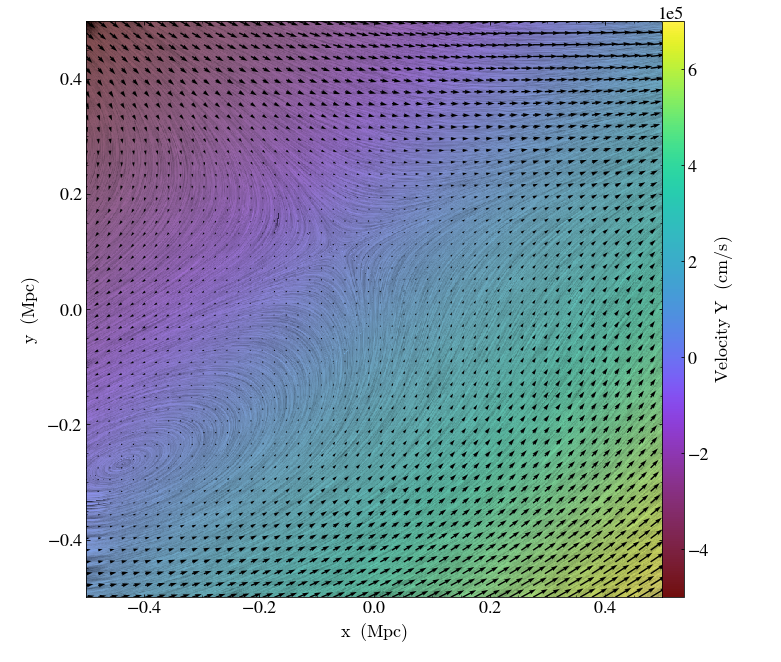

In [66]:
import yt

plot_LIC(U_grid = U.T, V_grid = V.T)
